# Current SARS-CoV-2 Viral Diversity Supports Transmission Rule-Out by Genomic Sequencing



When community transmission levels are high, there will be many coincidences in which individuals in the same workplace, classroom, nursing home, or other institution test positive for SARS-CoV-2 purely by chance. Genomic sequencing can separate such coincidences from true transmission clusters.

Demonstrating that an epidemiologically-linked cluster does not have genomic links provides reassurance to stakeholders that infection control practices are working. If an epidemiologically-linked cluster does have genomic links, transmission in the identified setting is more likely and decision-makers can focus on revising infection control practices or policies to prevent future transmission.

This is possible because the SARS-CoV-2 virus mutates, on average, once every 2 weeks. (See [nextstrain](https://nextstrain.org/ncov/gisaid/global?l=clock) for an up-to-date estimate. As of 10-01-21, the rate estimate was 23.87 substitutions per year, or one every 2.18 weeks.) If two people are part of the same transmission event (A infected B, or some C infected both A and B), then the genome sequences of the virus from each case involved will differ by at most 1 or 2 mutations.

![Nextstrain Clock Rate](img/nextstrain_clock.png)


The converse is not necessarily true: it is possible for the genomes of virus to match even when the cases are epidemiologically quite distant, especially when superspreader events are involved. (Early in the pandemic we [documented](https://twitter.com/thebasepoint/status/1278057767983448064) instances where a viral genomic sequence was observed identically across dozens of countries, and persisted for months.)

Inspired by a potential program doing sequencing in schools, we asked: at this point in the pandemic, how sensitive is genomic sequencing for ruling out transmission? If two cases are unrelated, if the epi link is a coincidence, will genomic sequencing tell you that?

The more diverse the circulating population of SARS-CoV-2, the more powerful sequencing will be.

### Analysis

To answer this question, we picked an American city with a very high level of genomic sequencing being done: San Diego, California. The [SEARCH Alliance](https://searchcovid.info/) has been sequencing SARS-CoV-2 for almost a year and a half, and over the summer, they regularly sequenced 10-20% of the reported daily cases. We chose to analyze samples from August 2021, because it is after the Delta sweep, and so represents the current pandemic phase, and has a large number of genomes already sequenced and deposited into GISAID.

We downloaded the 2429 high-quality genomes from August 2021 from GISAID, and computed their pairwise SNP distances using `snp-dists` on a `mafft` alignment.

![SEARCH Alliance](img/GISAID_download.png)

We define a *potential coincidental epi link* to be a pair of samples from the time period, with collection dates less than 2 weeks apart. We say that potential epi link would be ruled out if the genomes are more than 2 SNPs away from each other.

**We find that 99.5% of potential spurious epi links would be ruled out by sequencing!**

One way to think about this: a given person A was infected by one person B. Just 0.5% of the cases in the area have genotypes close enough to that of A to plausibly be the infector B, so the chances that a coincidentally epi-linked case is also a genetic link is very low.

Analysis below:

In [2]:
# Inputs
fasta_file = 'data/gisaid_auspice_input_hcov-19_2021_09_22_23/1632352915398.sequences.fasta'
meta_file = 'data/gisaid_auspice_input_hcov-19_2021_09_22_23/1632352915398.metadata.tsv'
reference_file = 'data/ref.fasta'

In [3]:
# Intermediates
working_dir = 'scratch/'
aligned_file = working_dir + 'aligned.aln'
dists_file = working_dir + 'snp-dists.tsv'

Align whole genomes to reference.

In [4]:
# Flags just align to reference
!/Users/batson/opt/anaconda3/bin/mafft  \
    --6merpair --keeplength --addfragments  \
    {fasta_file} {reference_file} > {aligned_file}

nadd = 2429
ppenalty_ex = -10
nthread = 0
blosum 62 / kimura 200
sueff_global = 0.100000
norg = 1
njobc = 2
generating a scoring matrix for nucleotide (dist=200) ... done


Making a distance matrix ..

There are 307202 ambiguous characters
    1 / 1
done.

nambiguous = 0 / 29903, ratio=0.000000
fTEP 499 / 2429                    
STEP 500 / 2429                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 600 / 2429                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 700 / 2429                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 800 / 2429                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 900 / 2429                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff

Compute SNP distances between samples.

In [5]:
!/Users/batson/opt/anaconda3/envs/llama/bin/snp-dists \
-m {aligned_file} > {dists_file}

This is snp-dists 0.7.0
Read 2430 sequences of length 29903


In [6]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns
%matplotlib inline

In [7]:
# Load metadata
meta = pd.read_csv(meta_file, sep='\t')
date_lookup = dict()
for sample, date in zip(meta['strain'], meta['date']):
    if pd.isna(date):
        print(f"Warning: {sample} is missing collection date.")
        date_lookup[sample] = np.nan
    else:
        date_lookup[sample] = datetime.datetime.strptime(date, '%Y-%m-%d').toordinal()

In [8]:
# Close = SNP dist <= 2, Far = SNP dist > 2, for samples collected 
# within 2 weeks of each other
close_pairs = 0
far_pairs = 0
distances = []
with open(dists_file, 'r') as infile:
    for line in tqdm.tqdm(infile):
        (sample1, sample2, distance) = line.split()
        distance = int(distance)
        if sample1 not in date_lookup or sample2 not in date_lookup:
            continue
        if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
            continue
        if sample1 == sample2:
            continue
        if distance <= 2:
            close_pairs += 1
        if distance > 2:
            far_pairs += 1
        distances.append(distance)

5904900it [00:06, 862350.34it/s]


In [9]:
close_pairs, far_pairs

(25930, 4729558)

In [10]:
np.round(100*far_pairs/(close_pairs + far_pairs), 1)

99.5

## Measuring Diversity Within and Between Lineages

A more detailed histogram of all pairwise SNP distances between samples collected within 2 weeks of one another shows a tri-modal plot.

Only pairs of samples on the far left (to the left of the 2-SNP red line) could have direct transmission links.

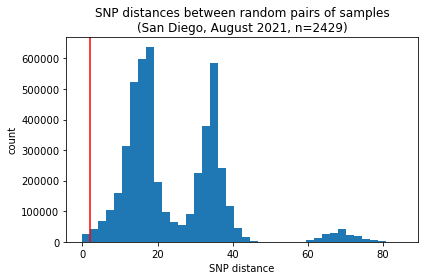

In [11]:
plt.hist(distances, bins = 40)
plt.title("SNP distances between random pairs of samples\n(San Diego, August 2021, n=2429)")
plt.xlabel('SNP distance')
plt.ylabel('count')
plt.axvline(2, color='red')
plt.tight_layout()
plt.savefig('SNP-dist-san-diego.png')

We then investigated the source of the three peaks for pairwise SNP distances: around 15, 35, and 70.

Presumably, these are generated by the typical distances within or between certain lineages. For example, the founding genotypes of  B.1.617.2 and P.1 (Delta and Gamma) are some distance apart on the tree, and the distance from any Delta to any Gamma should be approximately the same. (With a mutation rate of ~1 mut/2 weeks, the distance should be approximately the number of weeks since Delta and Gamma diverged.)

In [12]:
meta.groupby('pangolin_lineage')['date'].count().sort_values(ascending=False)

pangolin_lineage
B.1.617.2    1363
AY.25         355
AY.26         257
AY.20         139
AY.3           94
AY.14          72
AY.13          33
AY.2           31
P.1            21
AY.4           17
AY.3.1          8
AY.12           7
B.1.621         7
B.1.1.7         6
B.1.628         5
AY.1            4
AY.5            3
B.1             2
P.1.7           1
B.1.621.1       1
None            1
AY.10           1
Q.3             1
Name: date, dtype: int64

In [13]:
lineages = meta['pangolin_lineage'].unique()
n_lineages = len(lineages)

lin_to_row = dict(zip(lineages, range(n_lineages)))
sample_to_lin = dict(zip(meta['strain'], meta['pangolin_lineage']))

counts = np.zeros((n_lineages, n_lineages))
distances = np.zeros((n_lineages, n_lineages))
with open(dists_file, 'r') as infile:
    for line in tqdm.tqdm(infile):
        (sample1, sample2, distance) = line.split()
        if sample1 == sample2:
            continue
        distance = int(distance)
        if sample1 not in date_lookup or sample2 not in date_lookup:
            continue
        if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
            continue
        lin1 = sample_to_lin[sample1]
        lin2 = sample_to_lin[sample2]
#         distances.loc[lin1, lin2] += distance
#         counts.loc[lin1, lin2] += 1
        idx1 = lin_to_row[lin1]
        idx2 = lin_to_row[lin2]
        distances[idx1, idx2] += distance
        counts[idx1, idx2] += 1
distances = pd.DataFrame(index = lineages,
             columns = lineages,
             data = distances)
counts = pd.DataFrame(index = lineages,
             columns = lineages,
             data = counts)
mean_distances = distances/counts

5904900it [00:13, 449671.57it/s]


Remove None (uncalled lineages), and AY.10 (few pairs w/in 2 week window).

In [14]:
md = mean_distances.drop(['None', 'AY.10'], axis = 0).drop(['None', 'AY.10'], axis = 1)

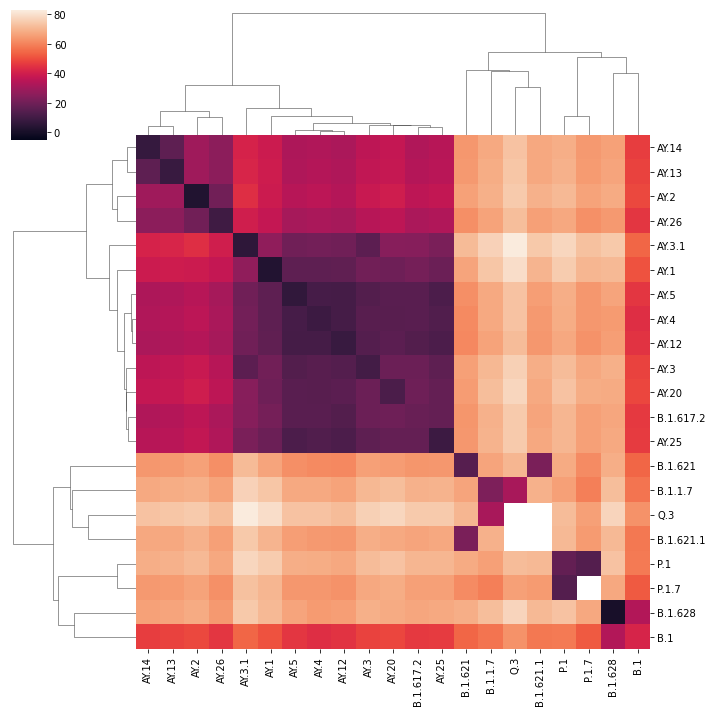

In [15]:
sns.clustermap(md.fillna(0), vmin=-5, mask=md.isna())

The distance between a typical Delta lineage (say, AY.25) and Gamma (P.1) is 71 SNPs. The lineages diverged in Jan 2020, or 86 weeks before these samples were collected.

In [16]:
mean_distances.loc['AY.25', 'P.1']

70.78243035378567

In contrast, the average distance between AY.3 and AY.25 samples is 16.6, which have a least common ancestor in April 2021, or 16 weeks before the samples were collected.

In [17]:
mean_distances.loc['AY.25', 'AY.3']

16.59278133261811

Even within PANGO lineages, there is significant diversity. The average distance within AY.25 is 8, meaning that most pairs could still be ruled out.

In [18]:
mean_distances.loc['AY.25', 'AY.25']

8.732012002204486

Inside Delta more broadly, those still categorized as `B.1.617.2`, the diversity is even greater.

In [19]:
mean_distances.loc['B.1.617.2', 'B.1.617.2']

18.41109050041531

In [20]:
within_lineage_distances = []
lineage_distribution = {}
with open(dists_file, 'r') as infile:
    for line in tqdm.tqdm(infile):
        (sample1, sample2, distance) = line.split()
        if sample1 == sample2:
            continue
        distance = int(distance)
        if sample1 not in date_lookup or sample2 not in date_lookup:
            continue
        if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
            continue
        lin1 = sample_to_lin[sample1]
        lin2 = sample_to_lin[sample2]
        if lin1 == lin2:
            within_lineage_distances.append(distance)
            if lin1 in lineage_distribution:
                lineage_distribution[lin1].append(distance)
            else:
                lineage_distribution[lin1] = [distance]

5904900it [00:07, 741219.69it/s]


In [21]:
(np.array(within_lineage_distances) > 2).sum()/len(within_lineage_distances)

0.9847742436879218

Even if we restrict ourselves to pairs of samples within the same PANGO lineage, 98.5% of samples are still more than 2 SNPs away.

This means that **for transmission cluster rule-out, it is essential to use actual SNP distances, and not just PANGO lineage assignments**. Relying on lineage assignments alone gives up substantial power.

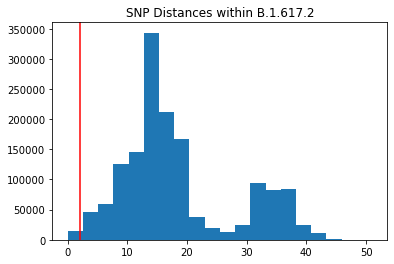

In [22]:
# Within lineage distances
plt.hist(lineage_distribution['B.1.617.2'], bins=20)
plt.title("SNP Distances within B.1.617.2")
plt.axvline(2, color='red')

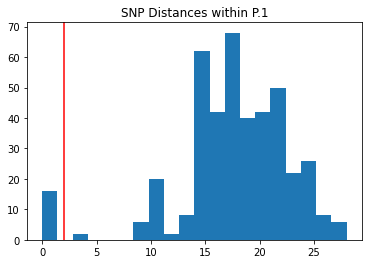

In [23]:
plt.hist(lineage_distribution['P.1'], bins=20)
plt.title("SNP Distances within P.1")
plt.axvline(2, color='red')

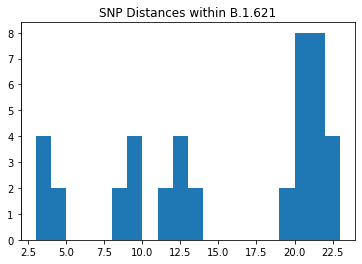

In [24]:
# Within lineage distances
plt.hist(lineage_distribution['B.1.621'], bins=20)
plt.title("SNP Distances within B.1.621")
plt.axvline(2, color='red')

(array([1.47600e+04, 4.54100e+04, 5.91420e+04, 1.25754e+05, 1.45540e+05,
        3.43344e+05, 2.11290e+05, 1.67816e+05, 3.80640e+04, 1.92040e+04,
        1.33240e+04, 2.47120e+04, 9.47840e+04, 8.19640e+04, 8.46780e+04,
        2.41180e+04, 1.14140e+04, 1.58600e+03, 3.80000e+02, 2.40000e+01]),
 array([ 0.  ,  2.55,  5.1 ,  7.65, 10.2 , 12.75, 15.3 , 17.85, 20.4 ,
        22.95, 25.5 , 28.05, 30.6 , 33.15, 35.7 , 38.25, 40.8 , 43.35,
        45.9 , 48.45, 51.  ]),
 <a list of 20 Patch objects>)

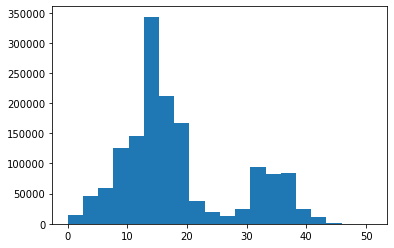

In [25]:
plt.hist(lineage_distribution['B.1.617.2'], bins=20)